In [1]:
import hyperopt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
import matplotlib.pyplot as plt   
import numpy as np
import pandas as pd  
import seaborn as sns
from sklearn import preprocessing
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, make_scorer, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
import xgboost as xgb

# Load and prepare the data

In [2]:
# Load the data
# This is a copy of UCI ML Breast Cancer Wisconsin (Diagnostic) datasets. https://goo.gl/U2Uwz2
# Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.
# 569 Rows and 30 features are used to train the model.
df = load_breast_cancer()

In [3]:
# Declare our feature vector and target variables
X = df.data
y = df.target

In [4]:
# Scale the data
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [5]:
# split to train and test
# train_test_split: Split arrays or matrices into random train and test subsets.
# test_size: If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split. If int, represents the absolute number of test samples. If None, the value is set to the complement of the train size. If train_size is also None, it will be set to 0.25.
# random_state: Controls the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls.
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=200)

# Fit the a simple model

In this example we fit our training data to an XGBoost model using default hyperparameters. The performance of this model is reported via accuracy.

In [6]:
# Instantiate an XGBClassifier instance
model = xgb.XGBClassifier()

# Fit the training data to the XGBClassifier instance
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Print our accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9473684210526315


# Tune parameters for one model type

Now we will add a search space and tune the hyperparameters for the XGBoost model. We've chosen a subset of the hyperparameters available to tune. Hyperparameters can easily be added or removed from the search space. 

The search space is a dictionary. In that dictionary our keys are kyperparameters and our values are lists of possible values for that hyperparameter. We use hyperopt to assign values from the list of possible values for each hyperparameter. We use the scope method to ensure that the hyperparameter is assigned the correct datatype.

Hyperopt's fmin method takes a search space, objective result, optimization algorithm, trials object, and number of iterations as input. It monitors the performance of each iteration (measured by the objective result) and returns the best hyperparameters.

In [7]:
# Initialize domain space for model types and parameters. 

# hp.choice(label, options) — Returns one of the options, which should be a list or tuple.
# hp.randint(label, upper) — Returns a random integer between the range [0, upper).
# hp.uniform(label, low, high) — Returns a value uniformly between low and high.
# hp.quniform(label, low, high, q) — Returns a value round(uniform(low, high) / q) * q, i.e it rounds the decimal values and returns an integer.
# hp.normal(label, mean, std) — Returns a real value that’s normally-distributed with mean and standard deviation sigma.

search_space = {
        'type': 'xgboost',
        'colsample_bytree': scope.float(hp.uniform('colsample_bytree', 0.5, 1)),
        'gamma' : hp.uniform('gamma', 1, 9),
        'eta' : scope.float(hp.uniform('eta', 0.01, 0.99)),
        'max_depth' : scope.int(hp.quniform("max_depth", 2, 5, 1)),
        'min_child_weight' : scope.int(hp.quniform('min_child_weight', 0, 10, 1)),
        'n_estimators' : scope.int(hp.uniform('n_estimator', 1, 1250)), 
        'reg_alpha' : scope.int(hp.quniform('reg_alpha', 1, 200, 1)),
        'reg_lambda' : scope.float(hp.uniform('reg_lambda', 0, 1)),
        }

In [8]:
def objective(params):
    """
    Custom objective function for hyperparameter tuning. Takes parameters and returns a score. The score is important because it is tracked by hyperopt and used to decide the next values for the hyperparameters.
    
    Parameters
    ----------
    params : dict
        Dictionary of parameters to be optimized.

    Returns
    -------
    score : float
    """
    
    classifier_type = params['type']
    del params['type']

    if classifier_type == 'svm':
        clf = SVC(**params)
    elif classifier_type == 'rf':
        clf = RandomForestClassifier(**params)
    elif classifier_type == 'logreg':
        clf = LogisticRegression(**params)
    elif classifier_type =='xgboost':
        clf = xgb.XGBClassifier(**params)
    else:
        return 0

    clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Because fmin() tries to minimize the objective, this function must return the negative accuracy. 
    return {'loss': -accuracy, 'status': STATUS_OK}

In [9]:
# trials.trials - a list of dictionaries representing everything about the search
# trials.results - a list of dictionaries returned by 'objective' during the search
# trials.losses() - a list of losses (float for each 'ok' trial)
# trials.statuses() - a list of status strings

trials = Trials()

best_result = fmin(
    fn=objective, 
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials)

best_params = hyperopt.space_eval(search_space, best_result)
print(best_params)

100%|██████████| 50/50 [01:11<00:00,  1.43s/trial, best loss: -0.9473684210526315]
{'colsample_bytree': 0.5460980008186828, 'eta': 0.4254946349367153, 'gamma': 6.118914322780659, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 1153, 'reg_alpha': 184, 'reg_lambda': 0.4690120583032986, 'type': 'xgboost'}


# Find the best model/parameters

We can evaluate several models at the same time. To do this we simply turn our search space into a list of dictionaries. Each dictionary is a model to evaluate. We can then use the trials object to track the performance of each model. The result tells us which model performed best.

In [10]:
search_space = hp.choice('classifier_type', [
    {
        'type': 'svm',
        'C': hp.lognormal('SVM_C', 0, 1.0),
        'kernel': hp.choice('kernel', ['linear', 'rbf'])
    },
    {
        'type': 'rf',
        'criterion': hp.choice('criterion', ['gini', 'entropy'])
    },
    {
        'type': 'logreg',
        'C': hp.lognormal('LR_C', 0, 1.0),
        'solver': hp.choice('solver', ['liblinear', 'lbfgs'])
    },
    {
        'type': 'xgboost',
        'colsample_bytree': scope.float(hp.uniform('colsample_bytree', 0.5, 1)),
        'gamma' : hp.uniform('gamma', 1, 9),
        'eta' : scope.float(hp.uniform('eta', 0.01, 0.99)),
        'max_depth' : scope.int(hp.quniform("max_depth", 2, 5, 1)),
        'min_child_weight' : scope.int(hp.quniform('min_child_weight', 0, 10, 1)),
        'n_estimators' : scope.int(hp.uniform('n_estimator', 1, 1250)), 
        'reg_alpha' : scope.int(hp.quniform('reg_alpha', 1, 200, 1)),
        'reg_lambda' : scope.float(hp.uniform('reg_lambda', 0, 1)),
    }
])

In [11]:
def objective(params):
    """
    Custom objective function for hyperparameter tuning. Takes parameters and returns a score.
    
    Parameters
    ----------
    params : dict
        Dictionary of parameters to be optimized.

    Returns
    -------
    score : float
    """
    
    classifier_type = params['type']
    del params['type']

    if classifier_type == 'svm':
        clf = SVC(**params)
    elif classifier_type == 'rf':
        clf = RandomForestClassifier(**params)
    elif classifier_type == 'logreg':
        clf = LogisticRegression(**params)
    elif classifier_type =='xgboost':
        clf = xgb.XGBClassifier(**params)
        
    else:
        return 0

    clf.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Because fmin() tries to minimize the objective, this function must return the negative accuracy. 
    return {'loss': -accuracy, 'status': STATUS_OK}

In [12]:
trials = Trials()

best_result = fmin(
    fn=objective, 
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials)

best_params = hyperopt.space_eval(search_space, best_result)
print(best_params)

100%|██████████| 50/50 [00:22<00:00,  2.20trial/s, best loss: -0.9473684210526315]
{'colsample_bytree': 0.5621100017085643, 'eta': 0.49590422470433626, 'gamma': 8.065737265073878, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 466, 'reg_alpha': 179, 'reg_lambda': 0.010830699565542168, 'type': 'xgboost'}


# Add cross validation

We can easily change how we evaluate the model. Previously we simply clculated a mean accuracy. Now we will use cross validation. We can use the sklearn.model_selection.cross_val_score method to evaluate each combination of hyperparameters. 

In [13]:
def objective(params):
    """
    Custom objective function for hyperparameter tuning. Takes parameters and returns a score.
    
    Parameters
    ----------
    params : dict
        Dictionary of parameters to be optimized.

    Returns
    -------
    score : float
    """
    
    classifier_type = params['type']
    del params['type']

    if classifier_type == 'svm':
        clf = SVC(**params)
    elif classifier_type == 'rf':
        clf = RandomForestClassifier(**params)
    elif classifier_type == 'logreg':
        clf = LogisticRegression(**params)
    elif classifier_type =='xgboost':
        clf = xgb.XGBClassifier(**params)
        
    else:
        return 0

    accuracy = make_scorer(accuracy_score)
    
    performance = cross_val_score(clf, X_scaled, y, scoring=accuracy).mean()

    # Because fmin() tries to minimize the objective, this function must return the negative accuracy. 
    return {'loss': -performance, 'status': STATUS_OK}

In [14]:
trials = Trials()

best_result = fmin(
    fn=objective, 
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials)

best_params = hyperopt.space_eval(search_space, best_result)
print(best_params)

100%|██████████| 50/50 [00:58<00:00,  1.16s/trial, best loss: -0.9841950007762769]
{'C': 0.34029464714571234, 'solver': 'liblinear', 'type': 'logreg'}


# Change our performance metric

Finally, we can change which metric we use to evaluate performance. This is done by simply changing what performance metric is reported in our objective function. In the example below we switch from accuracy to recall. We could easily monitor other performance metrics like precision or f1.

In [15]:
def objective(params):
    """
    Custom objective function for hyperparameter tuning. Takes parameters and returns a score.
    
    Parameters
    ----------
    params : dict
        Dictionary of parameters to be optimized.

    Returns
    -------
    score : float
    """
    
    classifier_type = params['type']
    del params['type']

    if classifier_type == 'svm':
        clf = SVC(**params)
    elif classifier_type == 'rf':
        clf = RandomForestClassifier(**params)
    elif classifier_type == 'logreg':
        clf = LogisticRegression(**params)
    elif classifier_type =='xgboost':
        clf = xgb.XGBClassifier(**params)
        
    else:
        return 0

    recall = make_scorer(recall_score)
    
    performance = cross_val_score(clf, X_scaled, y, scoring=recall).mean()

    # Because fmin() tries to minimize the objective, this function must return the negative accuracy. 
    return {'loss': -performance, 'status': STATUS_OK}

In [16]:
trials = Trials()

best_result = fmin(
    fn=objective, 
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials)

best_params = hyperopt.space_eval(search_space, best_result)
print(best_params)

  8%|▊         | 4/50 [00:13<02:34,  3.36s/trial, best loss: -0.9859154929577464]


KeyboardInterrupt: 

# Examine our new model

In [ ]:
def create_model(params):
    
    classifier_type = params['type']
    del params['type']

    if classifier_type == 'svm':
        clf = SVC(**params)
    elif classifier_type == 'rf':
        clf = RandomForestClassifier(**params)
    elif classifier_type == 'logreg':
        clf = LogisticRegression(**params)
    elif classifier_type =='xgboost':
        clf = xgb.XGBClassifier(**params)
    else:
        return 0
    
    return clf

model = create_model(best_params)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

# evaluate predictions
print("F1 Score: " + str(f1_score(y_test, y_pred, average='macro')))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))

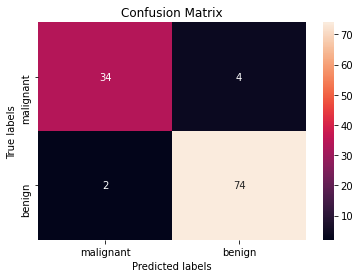

In [17]:
cm = confusion_matrix(y_test, y_pred)  

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['malignant', 'benign']); ax.yaxis.set_ticklabels(['malignant', 'benign']);